# LSTM

### 0. 데이터 세팅

In [1]:
import yfinance as yf
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd

# https://pytorch.org
# uv pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126 
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
year = 5
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = today - timedelta(days=365*year)
print(start_date, end_date)

data = yf.download(
    tickers = "NVDA", 
    start = start_date,
    end = end_date
)

data.head()

2020-09-10 2025-09-09


C:\Users\user\AppData\Local\Temp\ipykernel_9976\1867886687.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-09-10,12.274973,13.026222,12.130655,12.950449,698684000
2020-09-11,12.128163,12.614706,11.860216,12.448205,636928000
2020-09-14,12.833798,13.275226,12.593519,13.041926,1201744000
2020-09-15,12.952193,13.259024,12.789431,13.240330,727556000
2020-09-16,12.477116,13.053638,12.476368,12.918543,556384000


In [3]:
data.columns = data.columns.droplevel(1)
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-09-10,12.274973,13.026222,12.130655,12.950449,698684000
2020-09-11,12.128163,12.614706,11.860216,12.448205,636928000
2020-09-14,12.833798,13.275226,12.593519,13.041926,1201744000
2020-09-15,12.952193,13.259024,12.789431,13.240330,727556000
2020-09-16,12.477116,13.053638,12.476368,12.918543,556384000


In [4]:
data = data[['Close']]
data.head()

Price,Close
Date,
2020-09-10,12.274973
2020-09-11,12.128163
2020-09-14,12.833798
2020-09-15,12.952193
2020-09-16,12.477116


### 1. 데이터 분할

In [5]:
N = len(data)
print(N)

val_ratio = 0.1
test_ratio = 0.2

val_size = int(val_ratio * N)
test_size = int(test_ratio * N)
train_size = N - val_size - test_size 

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:(train_size + val_size)]
test_data = data.iloc[(train_size + val_size):]

print(f'Train Data : {train_data.shape}, Val Data : {val_data.shape}, Test Data : {test_data.shape}')

1254
Train Data : (879, 1), Val Data : (125, 1), Test Data : (250, 1)


### 2. 데이터 스케일러 적용

In [6]:
scaler = MinMaxScaler() # 여러 x값간의 절대값 차이로 인한 영향도를 줄이긴 위함
train_scaled = scaler.fit_transform(train_data.values) # train을 기준으로 transform을 진행하고 기억
val_scaled = scaler.transform(val_data.values) # fit_transform(새로운 기준)을 사용해서는 안됨(train 기준으로 변환해야 함)
test_scaled = scaler.transform(test_data.values)

print(f'train scaled : {train_scaled.dtype}')
print(f'val scaled : {val_scaled.dtype}')
print(f'test scaled : {test_scaled.dtype}')

print(f'scale 범위 : {scaler.data_min_}, {scaler.data_max_}')

train scaled : float64
val scaled : float64
test scaled : float64
scale 범위 : [11.21415997], [92.63212585]


### 3. 학습 데이터

In [7]:
# 같은 dataset안에서 x와 y를 생성 => 윈도우 크기만큼이 x, x+1 값을 예측값(y)으로 사용하여 활용
def make_dataset(data, window):
    dataX = []
    datay = []
    
    for i in range(0, data.shape[0] - window):
        
        x = data[i:(i + window), :]
        y = data[(i + window), [-1]]
        
        dataX.append(x)
        datay.append(y)
        
    return np.array(dataX), np.array(datay)

window=60

X_train, y_train = make_dataset(train_scaled, window=window) 
# window 만큼의 마지막 부분과 val_scaled의 합
X_val, y_val = make_dataset(np.concatenate([train_scaled[-window:], val_scaled]), window=window) 
X_test, y_test = make_dataset(np.concatenate([val_scaled[-window:], test_scaled]), window=window)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(819, 60, 1) (819, 1)
(125, 60, 1) (125, 1)
(250, 60, 1) (250, 1)


### 4. 데이터로더 만들기

In [8]:
# numpy => tensor
X_train_ts = torch.FloatTensor(X_train)
y_train_ts = torch.FloatTensor(y_train)
X_val_ts = torch.FloatTensor(X_val)
y_val_ts = torch.FloatTensor(y_val)
X_test_ts = torch.FloatTensor(X_test)
y_test_ts = torch.FloatTensor(y_test)

In [9]:
# Dataloader에 넣기 위해서는 class 형태여야 하는게 필요해서 class 형태로 변환
train_dataset = TensorDataset(X_train_ts, y_train_ts)
print(len(train_dataset))
print(train_dataset[0])

val_dataset = TensorDataset(X_val_ts, y_val_ts)
print(len(val_dataset))
print(val_dataset[0])

test_dataset = TensorDataset(X_test_ts, y_test_ts)
print(len(test_dataset))
print(test_dataset[0])

819
(tensor([[0.0130],
        [0.0112],
        [0.0199],
        [0.0213],
        [0.0155],
        [0.0149],
        [0.0115],
        [0.0155],
        [0.0170],
        [0.0107],
        [0.0135],
        [0.0199],
        [0.0219],
        [0.0242],
        [0.0280],
        [0.0290],
        [0.0222],
        [0.0293],
        [0.0305],
        [0.0333],
        [0.0317],
        [0.0308],
        [0.0365],
        [0.0367],
        [0.0349],
        [0.0333],
        [0.0314],
        [0.0276],
        [0.0294],
        [0.0279],
        [0.0259],
        [0.0287],
        [0.0232],
        [0.0263],
        [0.0169],
        [0.0218],
        [0.0158],
        [0.0163],
        [0.0217],
        [0.0312],
        [0.0357],
        [0.0406],
        [0.0292],
        [0.0186],
        [0.0266],
        [0.0271],
        [0.0251],
        [0.0278],
        [0.0266],
        [0.0267],
        [0.0268],
        [0.0225],
        [0.0232],
        [0.0209],
        [0.0243],
     

In [10]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 5. 모델 만들기

In [11]:
class LSTMRegressor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x): # 순전파(예측)
        
        # out : 모든 시점의 요약
        # hn : 마지막 시점의 hidden state
        # cn : 마지막 시점의 cell state
        out, (hn, cn) = self.lstm(x)
        pred = self.fc(hn[-1])
        
        return pred        

In [12]:
model = LSTMRegressor(
    input_size=1, 
    hidden_size=128, 
    num_layers=1, 
    dropout=0.2
)

model

LSTMRegressor(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

### 6. 학습하기

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
device

'cuda'

In [19]:
# 정의
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

best_val_loss = float('inf')
patience = 0
loss_history = []

In [ ]:
# 학습
for epoch in range(epochs):
    
    model.train()
    train_loss = []
    
    for data, target in train_dataloader:
        
        data = data.to(device)
        target = target.to(device)
        
        
        optimizer.zero_grad 
        pred = model(data)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    model.eval()
    
    val_loss = []
    
    with torch.no_grad():
        for data, target in val_dataloader:
            data = data.to(device)
            target = target.to(device)

            pred = model(target)
            loss = criterion(pred, target)
            val_loss.append(loss.item())
    
    train_loss = float(np.mean(train_loss))
    val_loss = float(np.mean(val_loss))
    
    loss_history.append(train_loss)
    print(f'Epoch : {epoch}, train_loss : {train_loss:.4f}, val_loss : {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'best.pt')        
    else:
        patience += 1
        if patience >= 10:
            break   
        
torch.save(model.state_dict(), 'last.pt')        

c:\walker\code\llm\.venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\walker\code\llm\.venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0, train_loss : 0.0302, val_loss : 0.7666
Epoch : 1, train_loss : 0.0291, val_loss : 0.9512
Epoch : 2, train_loss : 0.0406, val_loss : 0.9280
Epoch : 3, train_loss : 0.0322, val_loss : 0.7614
Epoch : 4, train_loss : 0.0366, val_loss : 0.4197
Epoch : 5, train_loss : 0.0519, val_loss : 0.3707
Epoch : 6, train_loss : 0.0591, val_loss : 0.5941
Epoch : 7, train_loss : 0.0281, val_loss : 0.9072
Epoch : 8, train_loss : 0.0444, val_loss : 0.9409
Epoch : 9, train_loss : 0.0236, val_loss : 0.7334
Epoch : 10, train_loss : 0.0306, val_loss : 0.5938


### 7. 시각화

Text(0, 0.5, 'loss')

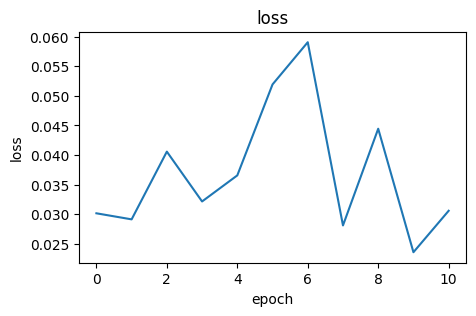

In [24]:
plt.figure(figsize=(5,3))
plt.plot(loss_history)
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")

### 8. 예측하기

In [25]:
# Validation 
model.eval()

test_loss_history = []
with torch.no_grad():
    for data, target in test_dataloader:
        data = data.to(device)
        target = target.to(device)

        pred = model(target)
        loss = criterion(pred, target)
        test_loss_history.append(loss.item())

print(float(np.mean(test_loss_history)))

1.3338748335838317


c:\walker\code\llm\.venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### 9. 예측 시각화

In [26]:
X_test_ts = torch.FloatTensor(X_test)
y_test_ts = torch.FloatTensor(y_test)

# 예측값 저장
pred_history = []
for i in range(len(X_test_ts)):
    with torch.no_grad():
        data = X_test_ts[i].to(device)
        pred = model(data.unsqueeze(dim=0))
        print(pred.item())
        pred_history.append(pred.item())

0.3734579086303711
0.37921902537345886
0.38381895422935486
0.39662206172943115
0.3926374316215515
0.3957655429840088
0.39973944425582886
0.3982711434364319
0.39026132225990295
0.3993024230003357
0.3950096666812897
0.396195650100708
0.4056335985660553
0.4054221212863922
0.4032345414161682
0.40348899364471436
0.4090288281440735
0.39777567982673645
0.40077900886535645
0.40791231393814087
0.4074261784553528
0.41104093194007874
0.42141106724739075
0.41765618324279785
0.42129403352737427
0.4231024980545044
0.4288724362850189
0.4149351418018341
0.428080290555954
0.4281359910964966
0.4246019124984741
0.43439149856567383
0.4329662322998047
0.42647990584373474
0.43315136432647705
0.4343886971473694
0.42779096961021423
0.4307958781719208
0.43026280403137207
0.4199772775173187
0.42878079414367676
0.4264192581176758
0.42811375856399536
0.4360065162181854
0.4393954277038574
0.4355179965496063
0.4351246953010559
0.44354671239852905
0.4353489875793457
0.43649739027023315
0.43153202533721924
0.43279057

In [27]:
# Scaler 되돌리기 
pred_inverse = scaler.inverse_transform(np.array(pred_history).reshape(-1,1))
# print(np.array(pred_history))
# print(np.array(pred_history).reshape(-1,1))
# print(pred_inverse)

y_test_inverse = scaler.inverse_transform(y_test_ts)

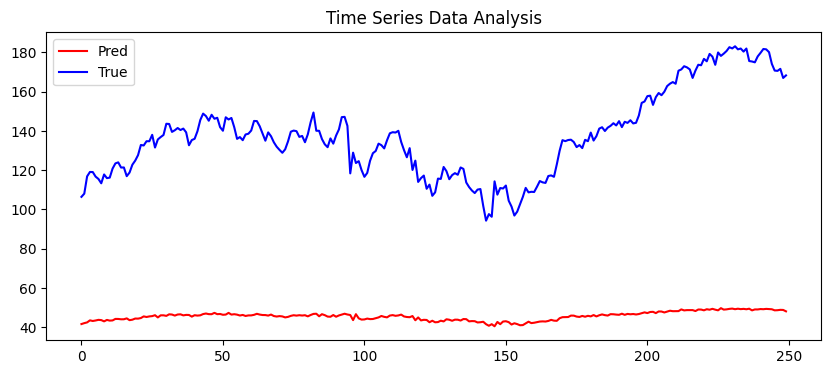

In [28]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label="Pred", color="r")
plt.plot(np.arange(len(y_test_inverse)), y_test_inverse, label="True", color="b")
plt.legend()
plt.title("Time Series Data Analysis")
plt.show()